
**Necessary Imports for Model Training and Evaluation**

In [22]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

**Loading Data and Adding Appropriate Columns**

In [23]:
print(torch.cuda.is_available())
total_data = pd.read_csv('full_miRNA_meta_dataset_normalized.csv')
total_data.replace('False', 0, inplace=True)
#case_id column is unnecessary for our purposes
total_data=total_data.drop(columns='case_id')

# Convert meta data into the appropriate data types
total_data=total_data.astype({'disease_type': 'int64', 'gender': 'float32', 'age':'float32', 'sample_type':'int64'})
#bin age into 0-15 range
total_data['age'] = round(total_data['age']/0.5)+8
total_data['age'] =total_data['age'].clip(0,15)


False


<ipython-input-23-89fb5d4893c4>:2: DtypeWarning: Columns (564) have mixed types. Specify dtype option on import or set low_memory=False.
  total_data = pd.read_csv('full_miRNA_meta_dataset_normalized.csv')


In [24]:
print(total_data.shape)
print(total_data.head())

(9648, 566)
   hsa-let-7a-1  hsa-let-7a-2  hsa-let-7a-3  hsa-let-7b  hsa-let-7c  \
0      0.413490      0.427207      0.410525    2.701892    3.117409   
1      0.223672      0.228731      0.211262    0.192889    1.618431   
2      1.113265      1.118690      1.138253    3.778653    0.962368   
3      1.889478      1.859932      1.889121    6.579528    2.105515   
4      5.507663      5.452986      5.498475    6.250827    5.033902   

   hsa-let-7d  hsa-let-7e  hsa-let-7f-1  hsa-let-7f-2  hsa-let-7g  ...  \
0    2.807810    1.264399     -0.918491     -0.911761   -0.954322  ...   
1    3.412194    1.059969     -0.946978     -0.949123   -1.226452  ...   
2    1.770967    3.159375     -0.944052     -0.946369   -1.105041  ...   
3    2.503992    0.919223     -0.937137     -0.942640   -0.963595  ...   
4    3.487847    1.529537     -0.724512     -0.728208   -0.552556  ...   

   hsa-mir-944  hsa-mir-95  hsa-mir-96  hsa-mir-98  hsa-mir-99a  hsa-mir-99b  \
0    -0.250482    0.072940   -0.5924

(8650, 566)
Training dataset
(8650, 564)
Solid tissue normal data shape: (633, 564)
Metastatic tissue data shape: (365, 564)
Combined test set shape: (998, 564)
18


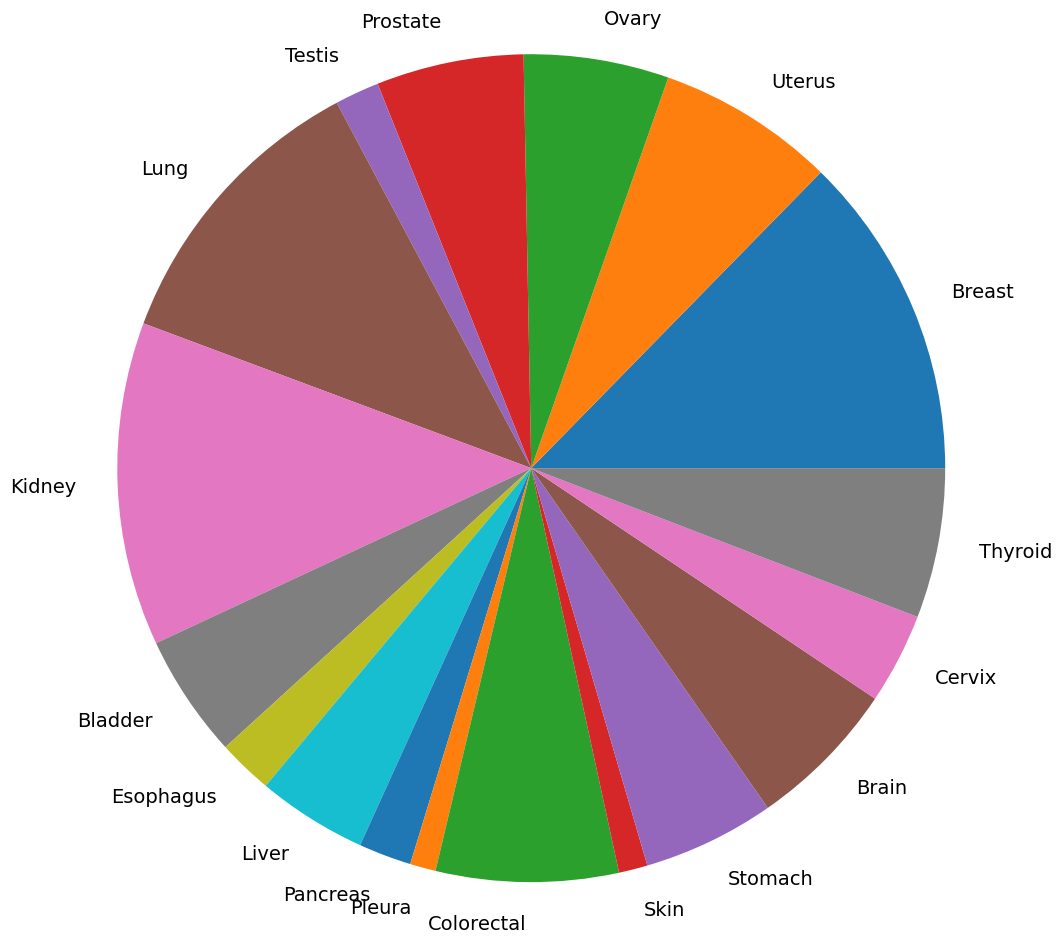

8650.0
[1096.  602.  490.  498.  150.  997. 1093.  417.  186.  372.  178.   87.
  616.   97.  446.  512.  307.  506.]


In [25]:
#by modifying isin parameter, can change data used for training
#0 = primary tumor, 1 = solid normal, 2 = metastatic
train =total_data[total_data['sample_type'].isin([0])]
train = train.sample(frac=1).reset_index(drop=True)
print(train.shape)

combined_test_set = total_data[total_data['sample_type'].isin([1,2])]
solid_tissue_normal = total_data[total_data['sample_type']==1]
solid_tissue_normal = solid_tissue_normal.sample(frac=1).reset_index(drop=True)
metastatic = total_data[total_data['sample_type']==2]

X= train.drop(columns=['disease_type', 'sample_type'])
print("Training dataset")
print(X.shape)
Y= train['disease_type']

X_solid_tissue_normal = solid_tissue_normal.drop(columns=['disease_type', 'sample_type'])
Y_solid_tissue_normal= solid_tissue_normal['disease_type']
print("Solid tissue normal data shape:", X_solid_tissue_normal.shape)

X_metastatic= metastatic.drop(columns=['disease_type', 'sample_type'])
Y_metastatic = metastatic['disease_type']
print("Metastatic tissue data shape:", X_metastatic.shape)

X_combined_test_set = combined_test_set.drop(columns=['disease_type', 'sample_type'])
Y_combined_test_set= combined_test_set['disease_type']
print("Combined test set shape:", X_combined_test_set.shape)

#make a pie chart of all different types of cancers present in training set
disease_labels=["Breast", "Uterus", "Ovary", "Prostate", "Testis" ,"Lung", "Kidney","Bladder","Esophagus", "Liver","Pancreas","Pleura","Colorectal",
                "Skin", "Stomach","Brain", "Cervix", "Thyroid"]
disease_count = np.zeros(len(disease_labels))
for i in range(len(disease_labels)):
    disease_count[i] = sum(Y==i)


print(len(disease_labels))
fig, ax = plt.subplots()
ax.pie(disease_count, labels=disease_labels,  radius = 2.8, textprops={'fontsize':14})
plt.show()

print(sum(disease_count))
print(disease_count)

**Function to generate ROC curve**

In [26]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import auc, roc_curve
from itertools import cycle
import matplotlib.pyplot as plt
import math
from sklearn.metrics import RocCurveDisplay

def plot_roc_auc_for_class(y_onehot_test, y_onehot_pred_test, labels, class_index):
  n_classes=len(labels)

  fig, ax = plt.subplots(figsize=(6, 6))
  fpr, tpr, thresholds= roc_curve(y_onehot_test[:, class_index], y_onehot_pred_test[:,class_index])
  roc_auc = auc(fpr, tpr)

  print(f"ROC AUC score:\n{roc_auc:.3f}")
  print(roc_auc)
  ax.grid()
  ax.plot(
      fpr,
      tpr,
      label=f"ROC curve (AUC = {roc_auc:.3f})",
      color="navy",
      linestyle=":",
      linewidth=4,
  )
  ax.set(title='ROC curve for metastatic skin cancer samples')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  ax.legend([f"ROC curve (AUC = {roc_auc:.3f})"])
  plt.show()

def plot_roc_curves(y_onehot_test, y_onehot_pred_test, labels):
# store the fpr, tpr, and roc_auc for all averaging strategies
  n_classes=len(labels)
  fpr, tpr, roc_auc = dict(), dict(), dict()
  thresholds=dict()
  fig, ax = plt.subplots(figsize=(6, 6))
  for i in range(n_classes):
      fpr[i], tpr[i], thresholds[i] = roc_curve(y_onehot_test[:, i], y_onehot_pred_test[:,i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  fpr_grid = np.linspace(0.0, 1.0, 1000)

  # Interpolate all ROC curves at these points
  mean_tpr = np.zeros_like(fpr_grid)
  class_cnt=0
  for i in range(n_classes):
      if not np.isnan(tpr[i]).any(): # np.isnan(fpr[i]):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation
        print(i)
        class_cnt +=1

  # Average it and compute AUC
  mean_tpr /= class_cnt

  fpr["macro"] = fpr_grid
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.3f}")
  print(roc_auc)
  ax.grid()
  plt.plot(
      fpr["macro"],
      tpr["macro"],
      color="navy",
      linestyle=":",
      linewidth=4,
  )
  ax.set(title='ROC curve for combined test set')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  ax.legend([f"macro-average ROC curve (AUC = {roc_auc['macro']:.3f})"])
  plt.show()


## Classifier Implementation

In [27]:
def call_classifier(clf_name, X, Y, X_test1, Y_test1, X_test2, Y_test2):
  '''
   Function takes training set and up to two test sets.
   Trains model and calculates accuracy of model on test sets.
   Plots a confusion matrix for each test set to visualize model performance.
  '''

  if clf_name == 'Random Forest':
    clf = RandomForestClassifier(n_estimators=64, max_depth=16)
  elif clf_name == 'Decision Tree':
    clf = DecisionTreeClassifier(max_depth=16)
  elif clf_name == 'Logistic Regression':
    clf = LogisticRegression(random_state=0, max_iter = 500)

  clf = clf.fit(X, Y)
  y_pred_train = clf.predict(X)
  y_pred1 = clf.predict(X_test1)
  y_pred2 = clf.predict(X_test2)

  acc_train=metrics.accuracy_score(Y, y_pred_train)
  acc_test1=metrics.accuracy_score(Y_test1, y_pred1)
  acc_test2 = metrics.accuracy_score(Y_test2, y_pred2)

  print(clf_name + ": Accuracy on train {:.3}, solid {:.3}, metastatic {:.3}".format(acc_train, acc_test1, acc_test2))

  conf_matrix = confusion_matrix(Y_test1, y_pred1, labels=list(range(len(disease_labels))))
  fig, ax = plt.subplots(figsize=(8,6), dpi=100)
  display = ConfusionMatrixDisplay(conf_matrix,display_labels=disease_labels)
  ax.set(title='Confusion Matrix on solid normal samples: ' + clf_name)
  display.plot(ax=ax, xticks_rotation = 60)

  conf_matrix = confusion_matrix(Y_test2, y_pred2, labels=list(range(len(disease_labels))))
  fig, ax = plt.subplots(figsize=(8,6), dpi=100)
  display = ConfusionMatrixDisplay(conf_matrix,display_labels=disease_labels)
  ax.set(title='Confusion Matrix: ' + clf_name)
  display.plot(ax=ax, xticks_rotation = 60)

  return clf

Call classifier function on Decision Tree, Random Forest, and Logistic Regression to observe classifier performance.

Decision Tree: Accuracy on train 0.982, solid 0.659, metastatic 0.694


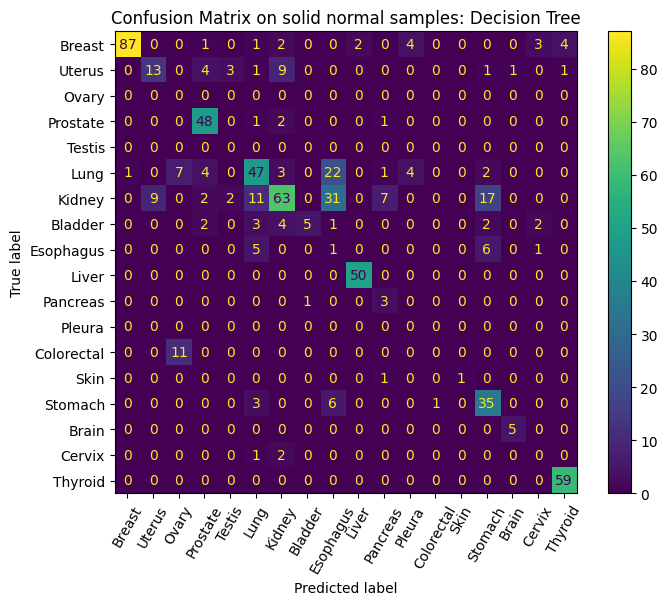

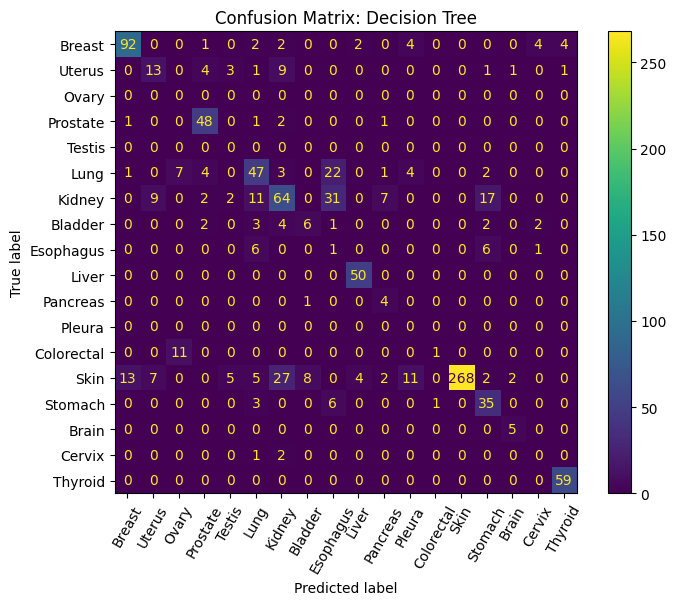

In [28]:
classifier = call_classifier("Decision Tree", X, Y, X_solid_tissue_normal, Y_solid_tissue_normal, X_combined_test_set, Y_combined_test_set)

Random Forest: Accuracy on train 1.0, solid 0.872, metastatic 0.884


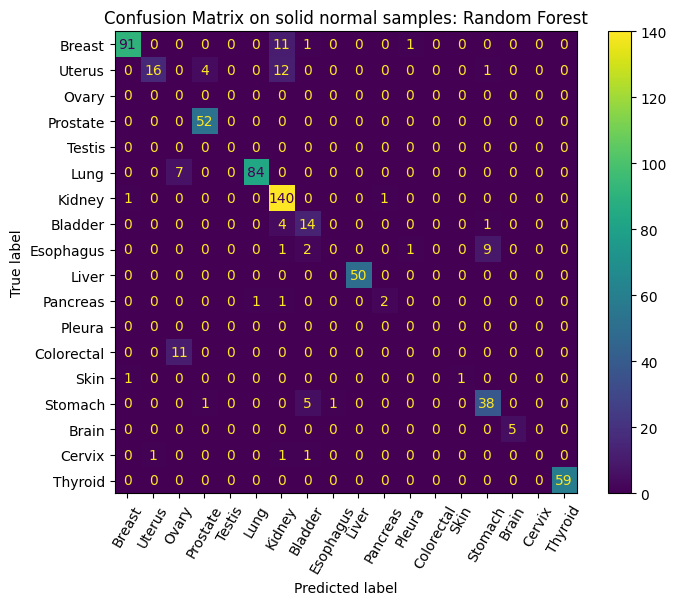

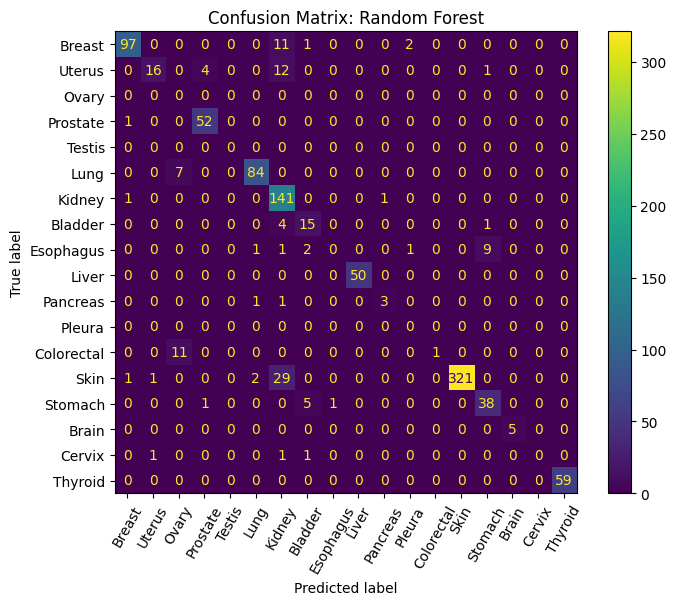

In [29]:
classifier = call_classifier("Random Forest", X, Y, X_solid_tissue_normal, Y_solid_tissue_normal, X_combined_test_set, Y_combined_test_set)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: Accuracy on train 1.0, solid 0.904, metastatic 0.894


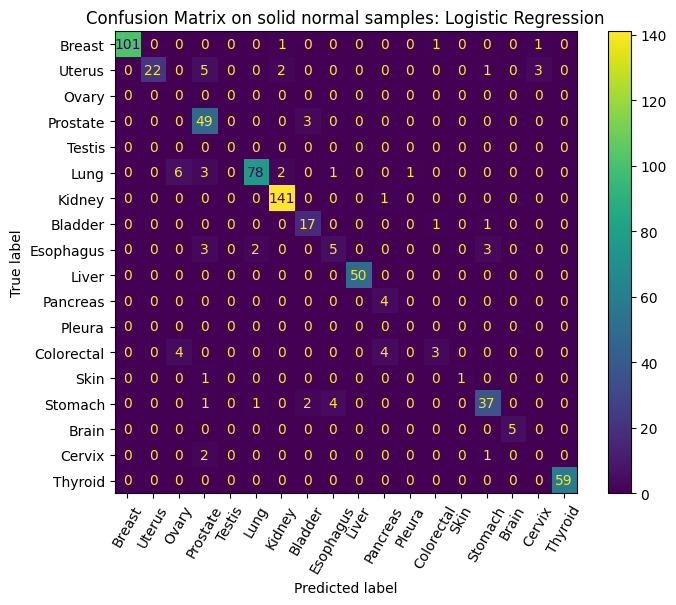

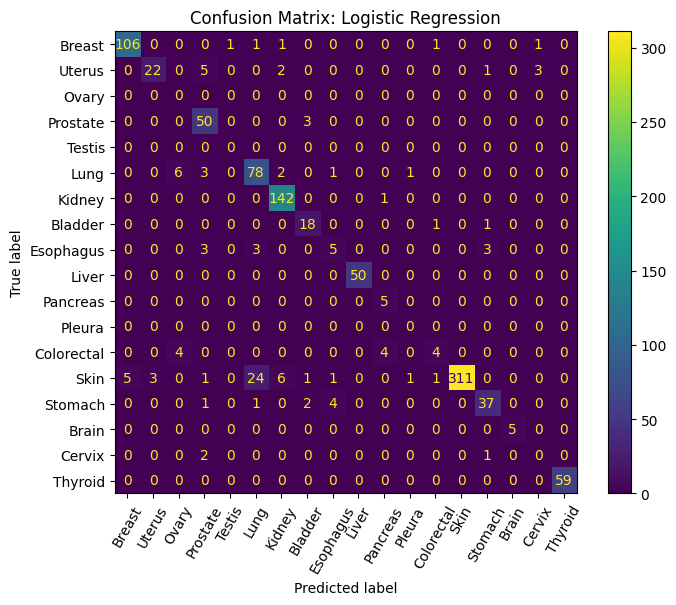

In [31]:
classifier = call_classifier("Logistic Regression", X, Y, X_solid_tissue_normal, Y_solid_tissue_normal, X_combined_test_set, Y_combined_test_set)

ROC AUC score:
0.993
0.9928325788679511


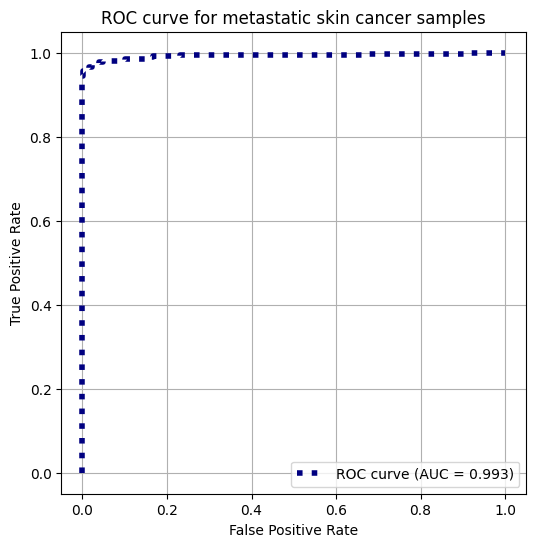

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


0
1
3
5
6
7
8
9
10
12
13
14
15
16
17
Macro-averaged One-vs-Rest ROC AUC score:
0.985
{0: 0.9747707120875104, 1: 0.9954780970325011, 2: nan, 3: 0.9973245482679445, 4: nan, 5: 0.9738420344815053, 6: 0.9974318079581237, 7: 0.9981083844580777, 8: 0.9783681765389083, 9: 1.0, 10: 0.9959718026183282, 11: nan, 12: 0.8916497633536173, 13: 0.9928325788679511, 14: 0.9940305468112394, 15: 1.0, 16: 0.9809045226130654, 17: 1.0, 'macro': 0.9845426862178118}


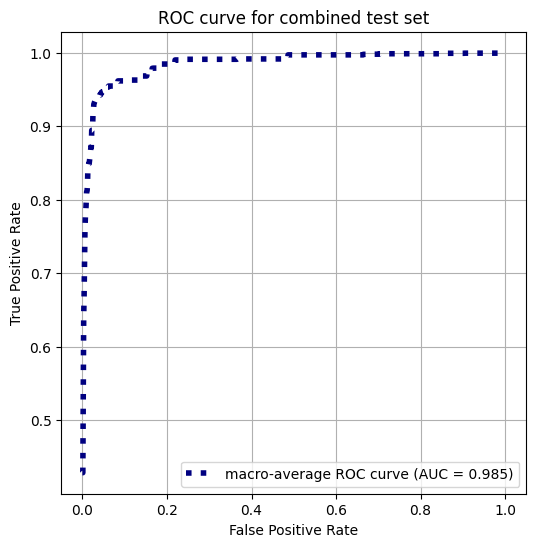

In [32]:
label_binarizer = LabelBinarizer().fit(Y)
y_onehot_test = label_binarizer.transform(Y_combined_test_set)
y_onehot_pred_test = classifier.predict_proba(X_combined_test_set)
#visualize performance of model on solely metastatic skin cancer samples:
plot_roc_auc_for_class(y_onehot_test, y_onehot_pred_test, disease_labels, 13)

#plot roc curve
plot_roc_curves(y_onehot_test, y_onehot_pred_test, disease_labels)

## Permutation Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(classifier, X_combined_test_set, Y_combined_test_set,n_repeats=50, random_state=0)

In [ ]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
       print(f"{X.columns[i]:<8}  "
             f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")


# Bar plot of importances
import pandas as pd
from matplotlib.pyplot import figure
cmap = plt.get_cmap('viridis')
colors = ['red','green','yellow'] #[cmap(i) for i in np.linspace(0, 1, len(X.columns))]
feat_importances = pd.Series(r.importances_mean, index = X.columns).sort_values(ascending = False)
feat_importances.nlargest(3).plot(kind = 'barh',color=colors)
plt.xlabel('Importance')
plt.ylabel('miRNA')


# Deep Learning Implementation

In [ ]:

def predict(model, X_test_tensor, y_test_tensor):
  '''
  This function returns performance of model on a given test set
  '''

  output = model(X_test_tensor)
  output_idx = torch.argmax(output, dim=1)
  prob = torch.nn.functional.softmax(output)
  correct_cnt = torch.sum(output_idx==y_test_tensor)
  accuracy = correct_cnt/y_test_tensor.size()[0]

  return accuracy, output_idx, prob


In [ ]:
#Creating class for the deep learning model
class network(nn.Module):
    def __init__(self,num_features, hidden, num_outputs, dropout):
        super(network, self).__init__()
        self.num_genes=num_features - 2
        self.dropout = nn.Dropout(p=dropout)
        self.gender = nn.Embedding(2,hidden)
        self.age = nn.Embedding(16,hidden)
        self.fc1 = nn.Linear(self.num_genes, 16*hidden)
        self.fc2 = nn.Linear(18*hidden, hidden)
        self.fc3 = nn.Linear(2*hidden,hidden)
        self.fc4 = nn.Linear(4*hidden,num_outputs)


    def forward(self, x):


        x2 = x[:,self.num_genes].long()
        x3 = x[:,self.num_genes+1].long()
        x1 = x[:,:self.num_genes]
        y = self.dropout(x1)
        y = self.fc1(y)
        y1= F.relu(y)
       # print(x1.size())
        y_gen = self.gender(x3)
        y_age = self.age(x2)

        y=y1
        y = torch.concat([y1,y_gen, y_age], dim=1)
        y = self.fc2(y)
        return y
        y = F.relu(y)
        y = self.fc3(y)
        y = F.relu(y)
        y = self.fc4(y)
        #return y


In [ ]:
num_classes=len(disease_labels)
numRNA=X.shape[1]
dropout = 0.4

model = network(numRNA, num_classes, num_classes,dropout)

loss = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


#convert X_train, y_train, X_test, y_test to tensors
X_train_tensor = torch.tensor(X.to_numpy(),dtype=torch.float32)
y_train_tensor = torch.tensor(Y.to_numpy(),dtype=torch.long)

X_solidnormal_tensor = torch.tensor(X_solid_tissue_normal.to_numpy(),dtype=torch.float32)
y_solidnormal_tensor = torch.tensor(Y_solid_tissue_normal.to_numpy(), dtype=torch.long)

X_metastatic_tensor = torch.tensor(X_metastatic.to_numpy(),dtype=torch.float32)
y_metastatic_tensor = torch.tensor(Y_metastatic.to_numpy(), dtype=torch.long)


#create lists to store the average losses over different epochs
train_loss_per_epoch_lst = []

acc_train_lst = []
acc_solidnormal_lst = []
acc_metastatic_lst = []

max_acc_solidnormal = -1000
max_acc_metastatic = -1000

noise_scale = 0
model.train()

#TRAINING
batch_size=16
for k in range(0,50):
  loss_lst = [] #stores average losses per batch
  for i in range(X_train_tensor.size()[0]//batch_size):

      batch_sample = X_train_tensor[batch_size*i:batch_size*(i+1),:]

      noise_sample = torch.rand(batch_sample.size())-0.5
      noise_sample = noise_sample*noise_scale # scaling the noise
      batch_sample = batch_sample+noise_sample

      batch_target = y_train_tensor[batch_size*i:batch_size*(i+1)]
      output = model(batch_sample)

      batch_loss = loss(output, batch_target)

      #calculate mean loss over batch, add to loss list
      l=torch.mean(batch_loss)
      loss_lst.append(l.detach().item())

      #back propagation - batch implementation is faster
       #calculate loss at the end of a batch
      l.backward()
      #updates the weights
      optimizer.step()
      #clear gradients of optimizer
      optimizer.zero_grad()

  avg = sum(loss_lst)/len(loss_lst)
  train_loss_per_epoch_lst.append(avg)

  #calculate performance on test set
  model.eval()
  accuracy_metastatic,output_metastatic, _ = predict(model, X_metastatic_tensor, y_metastatic_tensor)
  accuracy_solidnormal, output_solidnormal,_ = predict(model, X_solidnormal_tensor, y_solidnormal_tensor)
  accuracy_train,output_train,_ = predict(model, X_train_tensor, y_train_tensor)
  print("NN: Epoch {:2} Accuracy on metastatic {:.3} solid tissue {:.3} train {:.3}".format(k, accuracy_metastatic, accuracy_solidnormal, accuracy_train))
  if max_acc_solidnormal < accuracy_solidnormal:
    max_acc_solidnormal = accuracy_solidnormal
    best_output_solidnormal = output_solidnormal

  if max_acc_metastatic < accuracy_metastatic:
    max_acc_metastatic =accuracy_metastatic
    best_output_metastatic = output_metastatic

  acc_solidnormal_lst.append(accuracy_solidnormal)
  acc_metastatic_lst.append(accuracy_metastatic)
  acc_train_lst.append(accuracy_train)
  model.train()


print('max accuracy on solid tissue set', max_acc_solidnormal)
print('max accuracy on metastatic set', max_acc_metastatic)









Creating a confusion matrix for deep learning model

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_solidnormal_tensor, best_output_solidnormal,labels=list(range(len(disease_labels))))
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
display = ConfusionMatrixDisplay(conf_matrix,display_labels=disease_labels)
ax.set(title='Confusion Matrix on combined test set: Deep Learning')
display.plot(ax=ax, xticks_rotation = 60)

conf_matrix = confusion_matrix(y_metastatic_tensor, best_output_metastatic, labels=list(range(len(disease_labels))))
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
display = ConfusionMatrixDisplay(conf_matrix,display_labels=disease_labels)
ax.set(title='Confusion Matrix on metastatic samples: Deep Learning')
display.plot(ax=ax, xticks_rotation = 60)

Plot ROC curves for deep learning

In [ ]:
label_binarizer = LabelBinarizer().fit(Y)
y_onehot_test = label_binarizer.transform(Y_combined_test_set)
_,_,y_onehot_pred_test = predict(model, X_solidnormal_tensor , y_solidnormal_tensor)
#plot_roc_auc_for_class(y_onehot_test, y_onehot_pred_test.detach().numpy(), disease_labels, 13)
plot_roc_curves(y_onehot_test, y_onehot_pred_test.detach(), disease_labels)